In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re

from coarsening import mean_cells, mean_cells_ignore_ocean, median_round, most_common
# %matplotlib widget 
%matplotlib inline

dir_in = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test'
dir_out = '/p/scratch/cjibg36/kaandorp2/TSMP/setup_tsmp_cordex_109x106'
pffiles = glob.glob(os.path.join(dir_in,'input/parflow/*.sa'))
griddata_clm = xr.load_dataset(glob.glob(os.path.join(dir_in,'input/clm/griddata_*.nc'))[0] )

In [2]:
pffiles

['/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/slopey.sa',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/slopex.sa',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/parflow_436x424x15_cosmomask_indicator_FAOonly.sa']

In [3]:
def read_pffile(file):
    with open(file) as f:
        nx, ny, nz = [int(x) for x in next(f).split()] # read first line

        array = []
        for i1,line in enumerate(f): # read rest of lines
            array.append(float(line))

    data = np.array(array).reshape([nz,ny,nx])    
    return data

slopex = read_pffile( glob.glob(os.path.join(dir_in,'input/parflow/*slopex.sa'))[0] )
slopey = read_pffile( glob.glob(os.path.join(dir_in,'input/parflow/*slopey.sa'))[0] )
indicator = read_pffile( glob.glob(os.path.join(dir_in,'input/parflow/*indicator*.sa'))[0] )



In [4]:
n_coarse = 4

landmask_coarse = median_round( griddata_clm.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').construct(lsmlon=("lsmlon", "x_fine"), lsmlat=("lsmlat", "y_fine")),'LANDMASK').values

data_xr = xr.Dataset(data_vars=dict(DATA=(['z','y','x'],slopex),
                                    LANDMASK=(['y','x'],griddata_clm.LANDMASK.values)) )
data_xr_agg = data_xr.coarsen(dim={'x':n_coarse,'y':n_coarse},boundary='exact').construct(x=("x", "x_fine"), y=("y", "y_fine"))
data_slopex_coarse = mean_cells_ignore_ocean(data_xr_agg, 'DATA',cover_ocean=0,landmask_coarse=landmask_coarse)

data_xr = xr.Dataset(data_vars=dict(DATA=(['z','y','x'],slopey),
                                    LANDMASK=(['y','x'],griddata_clm.LANDMASK.values)) )
data_xr_agg = data_xr.coarsen(dim={'x':n_coarse,'y':n_coarse},boundary='exact').construct(x=("x", "x_fine"), y=("y", "y_fine"))
data_slopey_coarse = mean_cells_ignore_ocean(data_xr_agg, 'DATA',cover_ocean=0,landmask_coarse=landmask_coarse)

data_xr = xr.Dataset(data_vars=dict(DATA=(['z','y','x'],indicator),
                                    LANDMASK=(['y','x'],griddata_clm.LANDMASK.values)) )
data_xr_agg = data_xr.coarsen(dim={'x':n_coarse,'y':n_coarse},boundary='exact').construct(x=("x", "x_fine"), y=("y", "y_fine"))
data_indicator_coarse = most_common(data_xr_agg, 'DATA',cover_ocean=14,landmask_coarse=landmask_coarse)

In [15]:
def write_pffile(file,data_xr):
    with open(file, 'a') as f:
        nx, ny, nz = (len(data_xr.x),len(data_xr.y),len(data_xr.z))
        f.write('%i %i %i\n'%(nx,ny,nz))
        
        for val in data_xr.data.ravel():
            f.write(' %6.6e\n' % val)
            
write_pffile(os.path.join(dir_out,'input/parflow/slopex.sa'),data_slopex_coarse)
write_pffile(os.path.join(dir_out,'input/parflow/slopey.sa'),data_slopey_coarse)
write_pffile(os.path.join(dir_out,'input/parflow/parflow_indicator.sa'),data_indicator_coarse)


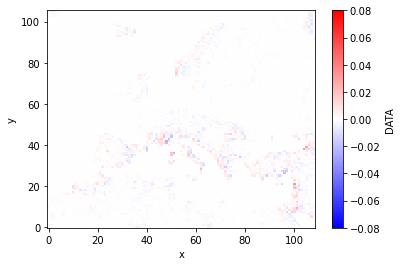

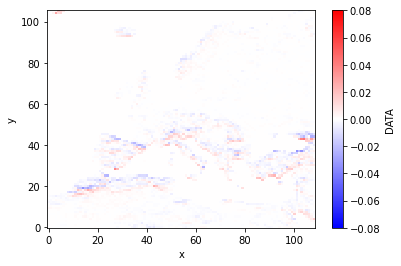

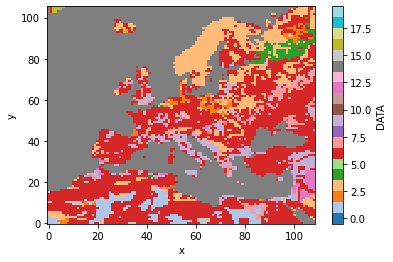

In [19]:

plt.figure()
data_slopex_coarse[0].plot.pcolormesh(cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)

plt.figure()
data_slopey_coarse[0].plot.pcolormesh(cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)

plt.figure()
data_indicator_coarse[0].plot.pcolormesh(cmap=plt.cm.tab20,vmin=-.5,vmax=19.5)


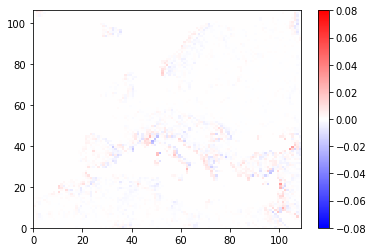

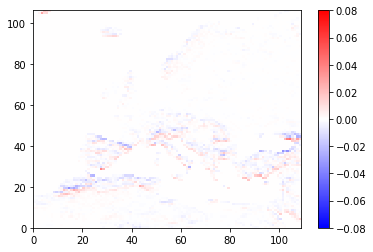

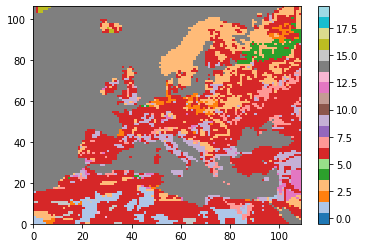

In [20]:
# double check: verify that reading the data again leads to the same results as above
data_read = read_pffile(os.path.join(dir_out,'input/parflow/slopex.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)
plt.colorbar()

data_read = read_pffile(os.path.join(dir_out,'input/parflow/slopey.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)
plt.colorbar()

data_read = read_pffile(os.path.join(dir_out,'input/parflow/parflow_indicator.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.tab20,vmin=-.5,vmax=19.5)
plt.colorbar()


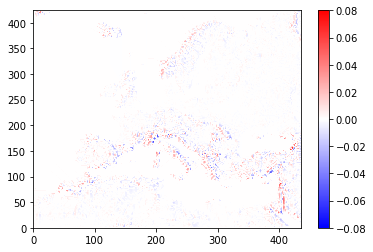

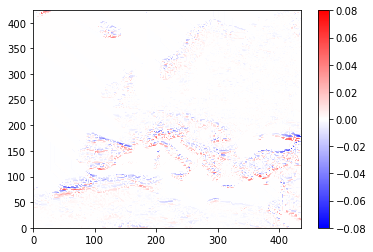

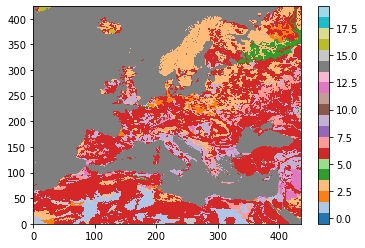

In [21]:
# double check: original files
data_read = read_pffile(os.path.join(dir_in,'input/parflow/slopex.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)
plt.colorbar()

data_read = read_pffile(os.path.join(dir_in,'input/parflow/slopey.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.bwr,vmin=-0.08,vmax=0.08)
plt.colorbar()

data_read = read_pffile(os.path.join(dir_in,'input/parflow/parflow_436x424x15_cosmomask_indicator_FAOonly.sa'))
plt.figure()
plt.pcolormesh(data_read[0,:,:],cmap=plt.cm.tab20,vmin=-.5,vmax=19.5)
plt.colorbar()

In [5]:
solfile = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_pf/geom_cordex0.11_436x424.pfsol'

#points, last line: 795162

with open(solfile) as f:
    next(f)
    n_points = int(next(f))
    
    i_start = 0
#     for i1,line in enumerate(f):
#         x,y,z= [int(x) for x in next(f).split()]
        
    array = []
    for i1,line in enumerate(f): # read rest of lines
        
        # next(f)

        if i1 == i_start + n_points:
            break

        array.append([float(x) for x in line.split()])

        
array = np.array(array,dtype=int)

In [53]:
array[1:,0] - array[:-1,0]

array([6250, 6250, 6250, ..., 6250, 6250, 6250])

In [7]:
3194250-3192750

1500

In [40]:
int(n_points)


795160

In [57]:
397580*2

795160

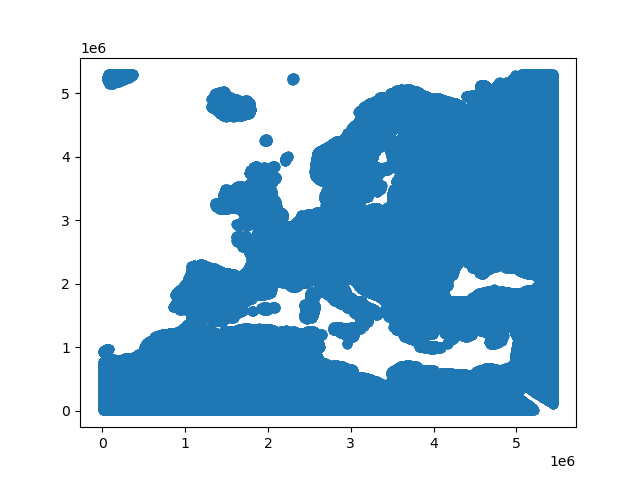

In [6]:
%matplotlib widget
plt.figure()
plt.plot(array[:,0],array[:,1],'o')

In [7]:
1.07**10

1.9671513572895665